In [ ]:
from zipfile import ZipFile

with ZipFile('scripts.zip', 'r') as zipp:
  zipp.extractall()

In [ ]:
import re
def delete_brackets(text):
  return re.sub('\(.+?\)', '', text)

In [ ]:
import os

directory = 'scripts'
for dirname in os.listdir(directory):
  newdir = os.path.join(directory, dirname)
  if not dirname.startswith('.'):
    for filename in os.listdir(newdir):
      with open(os.path.join(newdir, filename), 'r') as f:
        text = f.read()
      with open(os.path.join(newdir, filename), 'w') as f:
        f.write(delete_brackets(text))
      #print(os.path.join(newdir, filename))

## Create dfs

In [ ]:
import pandas as pd

films = {
    genre: {
        movie: {
            script: script,
            char_to_gen :
        }
    }
}

In [ ]:
def process_line(line, characters, df, c=0):
  sp = line[:line.find(',')]
  
  if sp not in characters.keys():
    characters[sp] = line[line.find(',')+2]

  return df.append({'scene':c, 'speaker':sp, 'line': line[line.find(':')+1:].strip()}, ignore_index=True)


def line_cond(line):
  if line != '\n' and len(line[line.find(':')+1:].strip())>1 and line[0].isalpha():
    if not (line.startswith('I , ') or line.startswith(' ') or line.startswith('SAMANTHA SUMMERS')):
      return True
  return False


def interpret_lines(filename):
  df = pd.DataFrame(columns=['scene', 'speaker', 'line'])
  c = 0
  characters = {}

  with open(filename, 'r') as f:
    for line in f:
      if line.startswith('---'):
        c += 1
      elif line_cond(line) :
        df = process_line(line, characters, df, c=c)
  return df, characters

In [ ]:
films = {'animation':{},
         'comedy':{},
         'crime':{},
         'drama':{},
         'horror':{}}

In [ ]:
directory = 'scripts'
for dirname in os.listdir(directory):
  newdir = os.path.join(directory, dirname)
  if not dirname.startswith('.'):
    for filename in os.listdir(newdir):
      keys = ['script', 'characters']
      values = interpret_lines(os.path.join(newdir, filename))
      films[dirname][filename[:filename.find('_')]] = {k: v for k, v in zip(keys, values)}
      print(os.path.join(newdir, filename))

scripts/comedy/yesman_dialog.txt
scripts/comedy/piratesofthecaribbean_dialog.txt
scripts/comedy/sexandthecity_dialog.txt
scripts/comedy/500daysofsummer_dialog.txt
scripts/comedy/rushhour_dialog.txt
scripts/crime/casino_dialog.txt
scripts/crime/batman_dialog.txt
scripts/crime/basicinstinct_dialog.txt
scripts/crime/godfather_dialog.txt
scripts/crime/gonein60seconds_dialog.txt
scripts/horror/interviewwiththevampire_dialog.txt
scripts/horror/psycho_dialog.txt
scripts/horror/saw_dialog.txt
scripts/horror/jaws_dialog.txt
scripts/horror/scream_dialog.txt
scripts/animation/up_dialog.txt
scripts/animation/toystory_dialog.txt
scripts/animation/megamind_dialog.txt
scripts/animation/shrekthethird_dialog.txt
scripts/animation/frozendisney_dialog.txt
scripts/drama/allabouteve_dialog.txt
scripts/drama/afterlife_dialog.txt
scripts/drama/americanbeauty_dialog.txt
scripts/drama/trumanshowthe_dialog.txt
scripts/drama/warrior_dialog.txt


## CLIQUE OR CONSEQ???

In [ ]:
import copy

In [ ]:
allf = {}
for k in films.keys():
  for f in films[k].keys():
    allf[f] = copy.deepcopy(films[k][f])

In [ ]:
for k,v in allf.items():
  v['script']['sp'] = v['script']['speaker'].apply(lambda x: x.upper())
  v['script'] = v['script'].loc[v['script']['speaker'] == v['script']['sp']]
  v['script'] = v['script'].drop(columns=['sp'])
  

  l = []
  for c in v['characters'].keys():
    if c != c.upper():
      l.append(c)
  for c in l:
    v['characters'].pop(c)

In [ ]:
no_scenes = ['shrekthethird', 'toystory' , 'piratesofthecarribean', 'rushhour', 'basicinstinct', 'casino', 'godfather', 'gonein60seconds', 'allabouteve', 'trumanshowthe', 'interviewwiththevampire', 'jaws', 'psycho', 'saw', 'scream']

In [ ]:
yes_scenes = ['up', 'megamind', 'frozendisney', 'yesman', 'piratesofthecaribbean', 'sexandthecity', '500daysofsummer', 'batman', 'afterlife', 'americanbeauty', 'warrior']

Там где есть деление на сцены

In [ ]:
def add_edges(ss, l,r):
  s = ss.split(',')
  for i in range(len(s) -1):
    for j in range(i+1, len(s)):
      jo = ','.join((s[i], s[j]))
      if (jo not in l.keys() and jo not in r):
        l[jo] = [s[i], s[j], 1]
        r.append(','.join((s[j], s[i])))
      else:
        if jo in l.keys():
          l[jo][2] += 1
        else:
          l[','.join((s[j], s[i]))][2] += 1
  return l

In [ ]:
for k,v in allf.items():
  if k not in no_scenes:
    v['primary'] = v['script'].groupby(['scene'])['speaker'].apply(lambda x: ','.join(set(x))).reset_index()
    v['primary']['line'] = v['script'].groupby(['scene'])['line'].apply(lambda x: ','.join(x)).reset_index()['line']

    l = {}
    r = []
    for sp in v['primary']['speaker'].tolist():
      l = add_edges(sp, l,r)

    v['graph'] = pd.DataFrame({'from':[v[0] for v in l.values()],
                               'to':[v[1] for v in l.values()],
                               'weight': [v[2] for v in l.values()],
                               'label': [3 if ''.join((v['characters'][c[0]], v['characters'][c[1]]))=='ff' else 1  for c in l.values()]})


Там где нет деления на сцены

In [ ]:
for k,v in allf.items():
  if k in no_scenes:
    #v['graph'] = pd.DataFrame(columns = ['from', 'to', 'weight'])
    roles = v['script']['speaker'].tolist()
    l={}
    r=[]
    for i in range(len(roles)-1):
      l = add_edges(','.join((roles[i],roles[i+1])), l,r)
    
    v['graph'] = pd.DataFrame({'from':[v[0] for v in l.values()],
                               'to':[v[1] for v in l.values()],
                               'weight': [v[2] for v in l.values()],
                               'label': [3 if ''.join((v['characters'][c[0]], v['characters'][c[1]]))=='ff' else 1  for c in l.values()]})

In [ ]:
for k,v in allf.items():
  if k in no_scenes:
    v['graph'] = v['graph'].loc[~(v['graph']['from'] == v['graph']['to'])]

## Визуализация

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def node_color(text):
  if text == 'f':
    return 'crimson'
  else:
    return 'yellowgreen'

def edge_color(n):
  if n == 3:
    return 'mediumvioletred'
  else:
    return 'yellowgreen'

def build_graph(df, characters):
  G = nx.Graph()
  for i in range(df.shape[0]):
    row = df.iloc[i]
    if row['from'] not in G.nodes():
      G.add_node(row['from'], color = node_color(characters[row['from']]), size = characters[row['from']])
    if row['to'] not in G.nodes():
      G.add_node(row['to'], color = node_color(characters[row['to']]), size = characters[row['to']])
    G.add_edge(row['from'], row['to'], color = edge_color(row['label']), width = 1/row['weight'])

  return G

    

In [ ]:
allf['up']['characters'][(allf['up']['graph'].iloc[3]['from'])]

'm'

In [ ]:
for k,v in allf.items():
  v['G'] = build_graph(v['graph'], v['characters'])

In [ ]:
def draw_graph(film):
  G0 = allf[film]['G']
  pos = nx.spring_layout(G0, weight='width')
  plt.figure(figsize=(25, 25))

  #вершины

  nx.draw_networkx_nodes(G0, pos, 
                        node_size=[1000 if v['size'] == 'f' else 10 for v in dict(G0.nodes()).values()], 
                        node_color = [v['color'] for v in dict(G0.nodes()).values()])

  #связи

  nx.draw_networkx_edges(G0, pos, 
                        edge_color = [G0[u][v]['color'] for u,v in G0.edges()],
                        width = [0.5 if G0[u][v]['color']=='yellowgreen' else 3 for u,v in G0.edges()])
                        #width = [G0[u][v]['width']*3 for u,v in G0.edges()])


  #лейблы
  nx.draw_networkx_labels(G0, pos,
                          labels = {k: k if v['size'] == 'f' else ' ' for k,v in dict(G0.nodes()).items()},
                          font_size=12, font_family='sans-serif')

  #nx.draw_networkx_edge_labels(G0, pos,
                              #edge_labels = {(u,v) : G0[u][v]['label'] for u,v in G0.edges()})

  plt.axis('off')
  plt.show()



In [ ]:
for k in films.keys():
  print(k)
  for f in films[k].keys():
    print(f)
    draw_graph(f)

crime
batman


In [ ]:
import statistics

In [ ]:
fbc = {}
obc = {}

for k, v in allf.items():
  b = nx.betweenness_centrality(v['G'], weight= 'width', normalized=False)
  fl = [u for p, u in b.items() if (v['characters'][p]=='f')]
  others = [u for p, u in b.items() if (v['characters'][p]!='f')]
  fbc[k] = statistics.mean(fl)
  obc[k] = statistics.mean(others)

In [ ]:
filmsdf = pd.read_csv('Untitled spreadsheet - Sheet1.csv')

In [ ]:
filmsdf['fem_bc'] = filmsdf['title'].apply(lambda x: fbc[x])
filmsdf['others_bc'] = filmsdf['title'].apply(lambda x: obc[x])

In [ ]:
filmsdf.head(2)

,scenes,title,com,SNA,genre,com=sna,fem_bc,others_bc
0,no,shrekthethird,yes,yes,animation,True,39.65,76.989583
1,no,toystory,no,no,animation,True,7.75,28.551724


In [ ]:
data.head(2)

,scenes,title,com,SNA,genre,com=sna,fem_bc,others_bc
0,no,shrekthethird,yes,yes,animation,True,39.65,76.989583
1,no,toystory,no,no,animation,True,7.75,28.551724


In [ ]:
data['bc_disc'] = data['fem_bc']-data['others_bc']

In [ ]:
print(data)

   scenes                    title  com  ...      fem_bc  others_bc     bc_disc
0      no            shrekthethird  yes  ...   39.650000  76.989583  -37.339583
1      no                 toystory   no  ...    7.750000  28.551724  -20.801724
2     yes                       up   no  ...    0.000000  16.900000  -16.900000
3     yes                 megamind   no  ...   28.214286  30.716216   -2.501931
5     yes             frozendisney  yes  ...   45.041667  10.846667   34.195000
7      no    piratesofthecaribbean  yes  ...    0.000000   0.000000    0.000000
8      no                 rushhour   no  ...   39.750000  35.587500    4.162500
10    yes            sexandthecity  yes  ...  102.958333   5.819444   97.138889
13     no                   casino  yes  ...  180.400000  50.948052  129.451948
14     no          gonein60seconds   no  ...    0.000000  50.878049  -50.878049
15     no              allabouteve  yes  ...   40.200000   3.160714   37.039286
16    yes           americanbeauty  yes 

In [ ]:
dataneg = copy.deepcopy(data[data['com']=='no'])
datapos = copy.deepcopy(data[data['com']=='yes'])

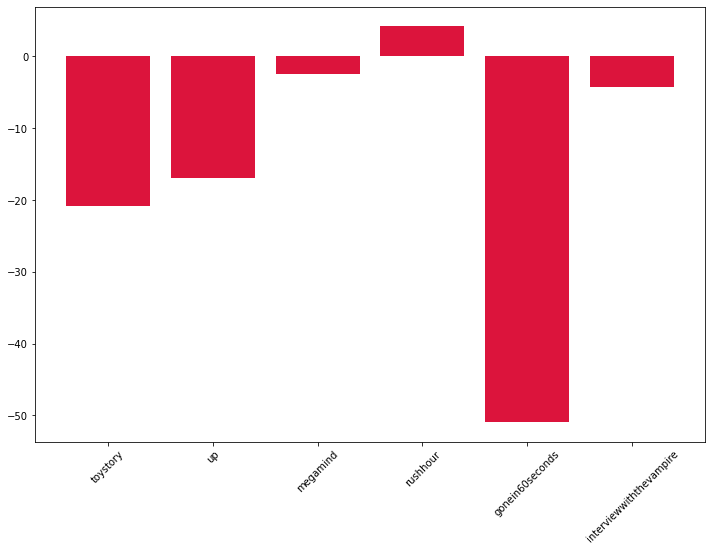

In [ ]:
plt.figure(figsize=(12, 8))
plt.bar(dataneg['title'], dataneg['bc_disc'], color = 'crimson')
plt.xticks(rotation=45)
plt.show()

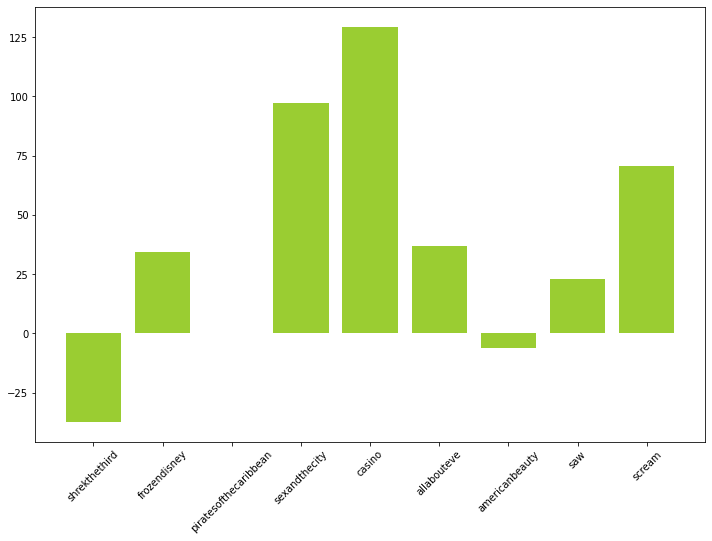

In [ ]:
plt.figure(figsize=(12, 8))
plt.bar(datapos['title'], datapos['bc_disc'], color = 'yellowgreen')
plt.xticks(rotation=45)
plt.show()